## Generating Belvarafenib Cobimetinib dose response curves for Western blot comparison

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy as cp
import itertools
import os
from pathlib import Path
import time
start_time = time.time()

Changes to main file directory. This works provided the "main_dir" has the correct directory name and the cwd starts within the main file directory. This might require tweaking under some high performance computing setups.

In [2]:
main_dir = "panRAFi_MEKi_combo"
for i in Path().resolve().parents:
    if i.parts[-1] == main_dir:
        os.chdir(i)

# Loads steady state responses

In [3]:
# Loads dose response dataframes
Belva_Cobi_SS_BRAF_V600E_dtf = pd.read_csv(Path('data/Model_steady_state_dose_responses/Belva_Cobi_SS_BRAF_V600E'))
Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf = pd.read_csv(Path('data/Model_steady_state_dose_responses/Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback'))
Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf = pd.read_csv(Path('data/Model_steady_state_dose_responses/Belva_Cobi_SS_NRAS_Q61_no_CRAF_feedback'))


# Selects the desired belvarafenib dose
belva_dose = list(set(Belva_Cobi_SS_BRAF_V600E_dtf['RAFi_0_uM'].to_list()))
belva_dose.sort()
belva_dose = belva_dose[5]

In [4]:
# Prepares BRAF_V600E dataframe for plotting
Belva_Cobi_SS_BRAF_V600E_dtf.loc[(np.isin(Belva_Cobi_SS_BRAF_V600E_dtf['RAFi_0_uM'],[0,belva_dose])) & (Belva_Cobi_SS_BRAF_V600E_dtf['MEKi_0_uM'] == 0),"MEKi_0_uM"] += 1e-3
BRAF_V600E_dtf = Belva_Cobi_SS_BRAF_V600E_dtf[np.isin(Belva_Cobi_SS_BRAF_V600E_dtf['RAFi_0_uM'],[0,belva_dose])]
BRAF_V600E_dtf = BRAF_V600E_dtf.rename(columns={"RAFi_0_uM":"Belva (nM)","MEKi_0_uM":"Cobi (nM)"})
BRAF_V600E_dtf.loc[:,"Belva (nM)"] = np.round(1000 * BRAF_V600E_dtf.loc[:,"Belva (nM)"])
BRAF_V600E_dtf.loc[:,"Cobi (nM)"] = np.round(1000 * BRAF_V600E_dtf.loc[:,"Cobi (nM)"])

# Prepares NRAS_Q61 with pRAF feedback dataframe for plotting
Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf.loc[(np.isin(Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf['RAFi_0_uM'],[0,belva_dose])) & (Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf['MEKi_0_uM'] == 0),"MEKi_0_uM"] += 1e-3
NRAS_Q61_w_CRAF_dtf = Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf[np.isin(Belva_Cobi_SS_NRAS_Q61_w_CRAF_dtf['RAFi_0_uM'],[0,belva_dose])]
NRAS_Q61_w_CRAF_dtf = NRAS_Q61_w_CRAF_dtf.rename(columns={"RAFi_0_uM":"Belva (nM)","MEKi_0_uM":"Cobi (nM)"})
NRAS_Q61_w_CRAF_dtf.loc[:,"Belva (nM)"] = np.round(1000 * NRAS_Q61_w_CRAF_dtf.loc[:,"Belva (nM)"])
NRAS_Q61_w_CRAF_dtf.loc[:,"Cobi (nM)"] = np.round(1000 * NRAS_Q61_w_CRAF_dtf.loc[:,"Cobi (nM)"])

# Prepares NRAS_Q61 without pRAF feedback dataframe for plotting
Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf.loc[(np.isin(Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf['RAFi_0_uM'],[0,belva_dose])) & (Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf['MEKi_0_uM'] == 0),"MEKi_0_uM"] += 1e-3
NRAS_Q61_n_CRAF_dtf = Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf[np.isin(Belva_Cobi_SS_NRAS_Q61_n_CRAF_dtf['RAFi_0_uM'],[0,belva_dose])]
NRAS_Q61_n_CRAF_dtf = NRAS_Q61_n_CRAF_dtf.rename(columns={"RAFi_0_uM":"Belva (nM)","MEKi_0_uM":"Cobi (nM)"})
NRAS_Q61_n_CRAF_dtf.loc[:,"Belva (nM)"] = np.round(1000 * NRAS_Q61_n_CRAF_dtf.loc[:,"Belva (nM)"])
NRAS_Q61_n_CRAF_dtf.loc[:,"Cobi (nM)"] = np.round(1000 * NRAS_Q61_n_CRAF_dtf.loc[:,"Cobi (nM)"])

# BRAF<sup>V600E</sup> dose/response simulation results

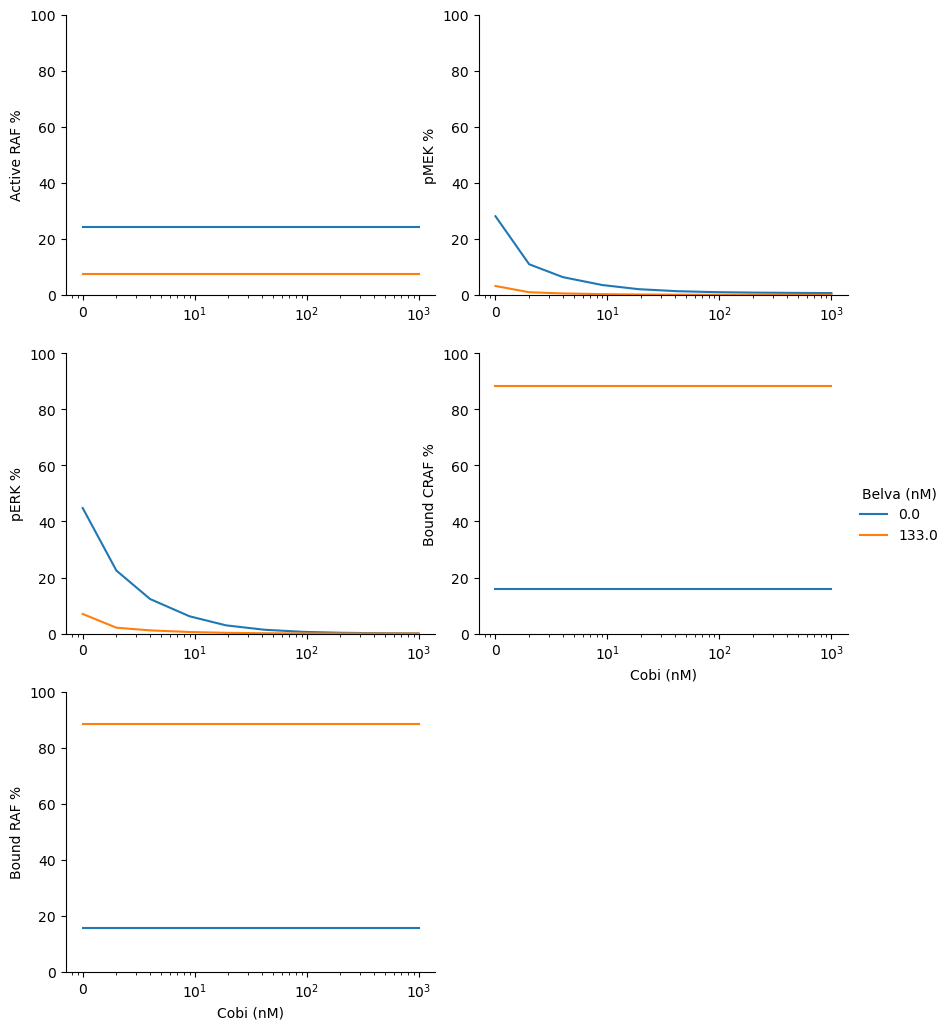

In [5]:
# format dataframe for FacetGrid
BRAF_V600E_melted = BRAF_V600E_dtf.melt(id_vars=['Cobi (nM)','Belva (nM)'])

# Declare variables to plot and set their max values
obs_array = np.array(["Active_RAF_percent","Bound_CRAF_percent","Bound_BRAF_percent","Bound_RAF_percent","pERK_percent","pMEK_percent"])
upper_bound = {"Active_RAF_percent":100,"Bound_CRAF_percent":100,"Bound_BRAF_percent":100,"Bound_RAF_percent":100,"pERK_percent":100,"pMEK_percent":100}
selected_obs_BRAF_V600E_melted = BRAF_V600E_melted[np.isin(BRAF_V600E_melted["variable"],obs_array)]

# Generates plots
g = sns.FacetGrid(
    selected_obs_BRAF_V600E_melted, col='variable', hue='Belva (nM)', col_wrap=2,
    sharex=False, sharey=False, height=3.5, aspect=1.25
)
# palette = ["red","blue"]
g.map(plt.plot, 'Cobi (nM)', 'value')
for ax_ind in range(len(g.axes)):
    _, ymax = g.axes[ax_ind].get_ylim()
    upper_bound_val = upper_bound[g.axes[ax_ind].get_title().replace("variable = ",'')]
    g.axes[ax_ind].set_ylim(ymin=0, ymax=upper_bound_val)
    
    g.axes[ax_ind].set_xscale('log')
    g.axes[ax_ind].set_xticks([1,10,100,1000])
    g.axes[ax_ind].set_xticklabels([0,"$10^{1}$","$10^{2}$","$10^{3}$"])
    g.axes[ax_ind].axvline(0, color='k', linewidth=0.5, linestyle='--')
    g.axes[ax_ind].set_ylabel(g.axes[ax_ind].get_title().replace("variable = ",'').replace("_"," ").replace("percent","%"))
    g.axes[ax_ind].set_title("")
    
g.set_xlabels('Cobi (nM)')
g.add_legend()

# Saves figure
g.savefig(Path('figures/Model_predicted_ss_dose_response_plots/BRAF_V600E.svg'),format = 'svg')

# NRAS<sup>Q61</sup> with pRAF feedback dose/response simulation results

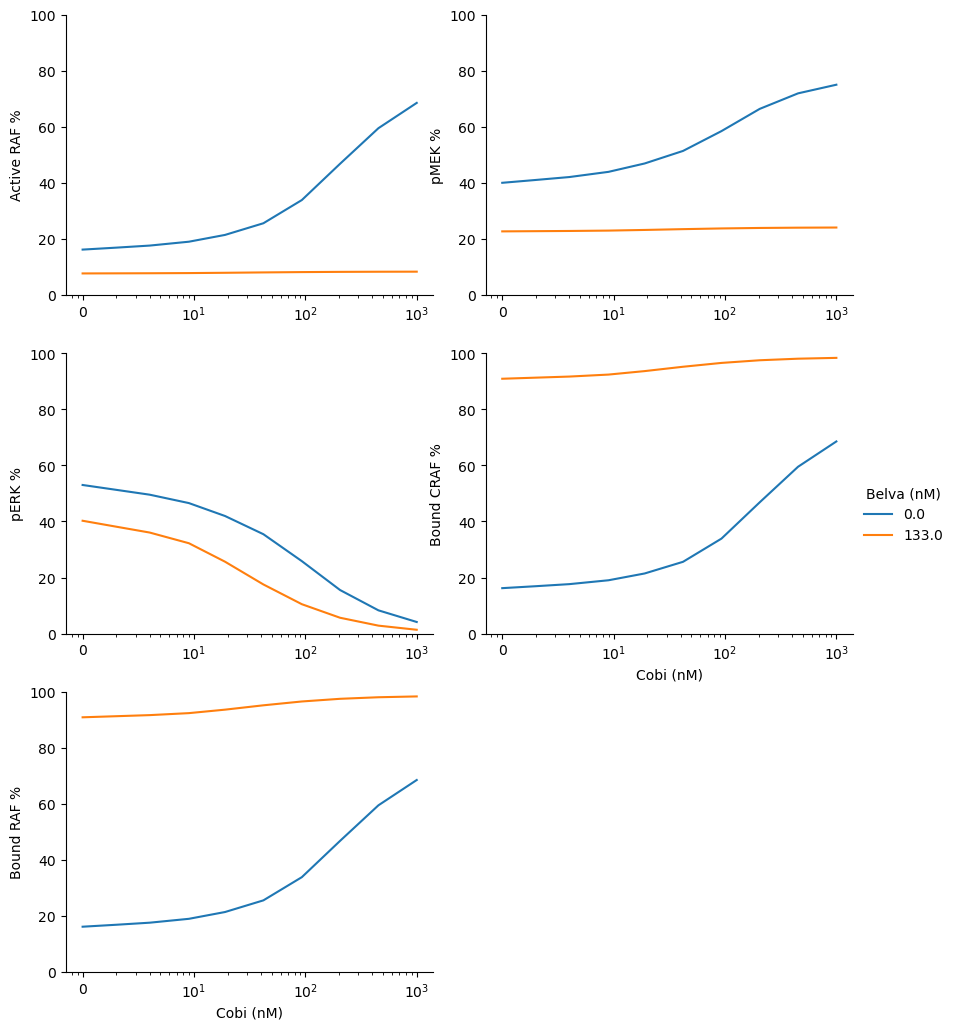

In [6]:
# format dataframe for FacetGrid
NRAS_Q61_w_CRAF_melted = NRAS_Q61_w_CRAF_dtf.melt(id_vars=['Cobi (nM)','Belva (nM)'])

# Declare variables to plot and set their max values
obs_array = np.array(["Active_RAF_percent","Bound_CRAF_percent","Bound_BRAF_percent","Bound_RAF_percent","pERK_percent","pMEK_percent"])
upper_bound = {"Active_RAF_percent":100,"Bound_CRAF_percent":100,"Bound_BRAF_percent":100,"Bound_RAF_percent":100,"pERK_percent":100,"pMEK_percent":100}
selected_obs_NRAS_Q61_w_CRAF_melted = NRAS_Q61_w_CRAF_melted[np.isin(NRAS_Q61_w_CRAF_melted["variable"],obs_array)]

# Generates plots
g = sns.FacetGrid(
    selected_obs_NRAS_Q61_w_CRAF_melted, col='variable', hue='Belva (nM)', col_wrap=2,
    sharex=False, sharey=False, height=3.5, aspect=1.25
)
g.map(plt.plot, 'Cobi (nM)', 'value')
for ax_ind in range(len(g.axes)):
    _, ymax = g.axes[ax_ind].get_ylim()
    upper_bound_val = upper_bound[g.axes[ax_ind].get_title().replace("variable = ",'')]
    g.axes[ax_ind].set_ylim(ymin=0, ymax=upper_bound_val)
    
    g.axes[ax_ind].set_xscale('log')
    g.axes[ax_ind].set_xticks([1,10,100,1000])
    g.axes[ax_ind].set_xticklabels([0,"$10^{1}$","$10^{2}$","$10^{3}$"])
    g.axes[ax_ind].axvline(0, color='k', linewidth=0.5, linestyle='--')
    g.axes[ax_ind].set_ylabel(g.axes[ax_ind].get_title().replace("variable = ",'').replace("_"," ").replace("percent","%"))
    g.axes[ax_ind].set_title("")
    
g.set_xlabels('Cobi (nM)')
g.add_legend()

# Saves figure
g.savefig(Path('figures/Model_predicted_ss_dose_response_plots/NRAS_Q61_w_CRAF_Feedback.svg'),format = 'svg')

# NRAS<sup>Q61</sup> without pRAF feedback dose/response simulation results

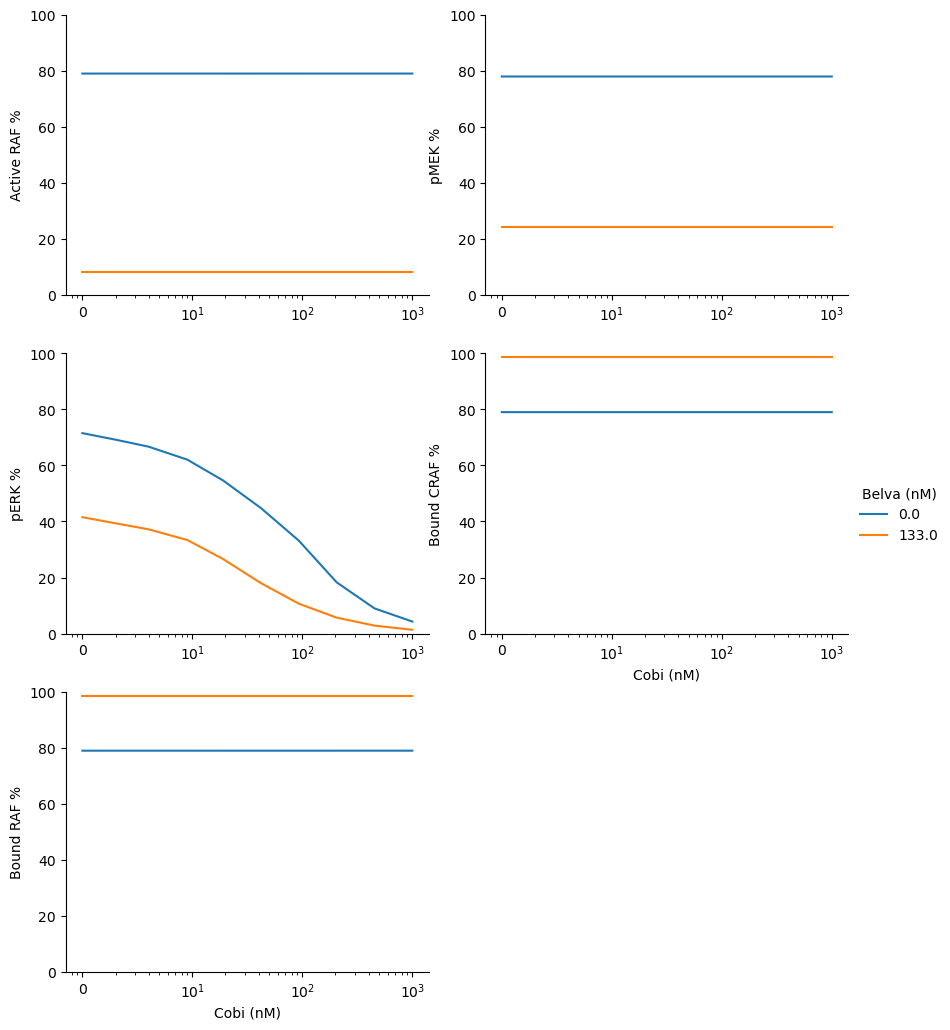

In [7]:
# format dataframe for FacetGrid
NRAS_Q61_n_CRAF_melted = NRAS_Q61_n_CRAF_dtf.melt(id_vars=['Cobi (nM)','Belva (nM)'])

# Declare variables to plot and set their max values
obs_array = np.array(["Active_RAF_percent","Bound_CRAF_percent","Bound_BRAF_percent","Bound_RAF_percent","pERK_percent","pMEK_percent"])
upper_bound = {"Active_RAF_percent":100,"Bound_CRAF_percent":100,"Bound_BRAF_percent":100,"Bound_RAF_percent":100,"pERK_percent":100,"pMEK_percent":100}
selected_obs_NRAS_Q61_n_CRAF_melted = NRAS_Q61_n_CRAF_melted[np.isin(NRAS_Q61_n_CRAF_melted["variable"],obs_array)]

# Generates plots
g = sns.FacetGrid(
    selected_obs_NRAS_Q61_n_CRAF_melted, col='variable', hue='Belva (nM)', col_wrap=2,
    sharex=False, sharey=False, height=3.5, aspect=1.25
)
g.map(plt.plot, 'Cobi (nM)', 'value')
for ax_ind in range(len(g.axes)):
    _, ymax = g.axes[ax_ind].get_ylim()
    upper_bound_val = upper_bound[g.axes[ax_ind].get_title().replace("variable = ",'')]
    g.axes[ax_ind].set_ylim(ymin=0, ymax=upper_bound_val)
    
    g.axes[ax_ind].set_xscale('log')
    g.axes[ax_ind].set_xticks([1,10,100,1000])
    g.axes[ax_ind].set_xticklabels([0,"$10^{1}$","$10^{2}$","$10^{3}$"])
    g.axes[ax_ind].axvline(0, color='k', linewidth=0.5, linestyle='--')
    g.axes[ax_ind].set_ylabel(g.axes[ax_ind].get_title().replace("variable = ",'').replace("_"," ").replace("percent","%"))
    g.axes[ax_ind].set_title("")
    
g.set_xlabels('Cobi (nM)')
g.add_legend()

# Saves figure
g.savefig(Path('figures/Model_predicted_ss_dose_response_plots/NRAS_Q61_no_CRAF_Feedback.svg'),format = 'svg')

In [8]:
print("Elapsed Time = "+str(time.time() - start_time) + " seconds")
!conda env export --name quant_bio

Elapsed Time = 2.327105760574341 seconds
name: quant_bio
channels:
  - conda-forge
  - alubbock
  - defaults
dependencies:
  - anyio=4.2.0=py311hca03da5_0
  - appnope=0.1.2=py311hca03da5_1001
  - argon2-cffi=21.3.0=pyhd3eb1b0_0
  - argon2-cffi-bindings=21.2.0=py311h80987f9_0
  - asttokens=2.0.5=pyhd3eb1b0_0
  - async-lru=2.0.4=py311hca03da5_0
  - attrs=23.1.0=py311hca03da5_0
  - babel=2.11.0=py311hca03da5_0
  - beautifulsoup4=4.12.2=py311hca03da5_0
  - bionetgen=2.9.1=0
  - blas=1.0=openblas
  - bleach=4.1.0=pyhd3eb1b0_0
  - bottleneck=1.3.7=py311hb9f6ed7_0
  - brotli=1.0.9=h1a28f6b_7
  - brotli-bin=1.0.9=h1a28f6b_7
  - brotli-python=1.0.9=py311h313beb8_7
  - bzip2=1.0.8=h80987f9_5
  - ca-certificates=2024.2.2=hf0a4a13_0
  - certifi=2024.2.2=py311hca03da5_0
  - cffi=1.16.0=py311h80987f9_0
  - charset-normalizer=2.0.4=pyhd3eb1b0_0
  - comm=0.2.1=py311hca03da5_0
  - contourpy=1.2.0=py311h48ca7d4_0
  - cycler=0.11.0=pyhd3eb1b0_0
  - cython=3.0.8=py311h80987f9_0
  - debugpy=1.6.7=py311h313